In [29]:
import requests, pandas as pd, matplotlib.pyplot as plt
import numpy as np
from ipywidgets import SelectMultiple, interact, Dropdown
from wordcloud import WordCloud, STOPWORDS

In [30]:
# kubectl port-forward svc/router 8888:80 -n fission
BASE_URL = "http://127.0.0.1:8888/data-filter"

# Cost Living

In [50]:
cost_living_payload = {
    "content": [
        "cost", "rent", "price", "grocery", "transport", "bill", "living", "wage", "income", "expensive", "afford",
        "renting", "apartment", "real estate", "landlord", "tenant", "lease", "mortgage", "housing", "electricity",
        "gas", "water", "utility", "power bill", "food", "meal", "dining", "supermarket", "shopping", "financial",
        "budget", "ripoff", "overpriced", "cheapest", "cheaper", "cheap", "struggle", "student loan", "university",
        "school", "tuition", "doctor", "hospital", "medicare", "insurance", "healthcare", "uber", "taxi",
        "public transport", "car", "petrol", "fuel"],
    "tags":     [],
    "keywords": ["brisbane", "melbourne", "sydney", "perth", "adelaide"],
    "combine":  "and",
    "size":     10000,
    "max_docs": 500000,
    "date_range": {
        "from": "01-01-2023",
        "to":   "31-12-2026"
    }
}

resp = requests.post(BASE_URL, json=cost_living_payload, timeout=120)
resp.raise_for_status()

data = resp.json()
print("Total hits:", data["total"])

docs = resp.json()["data"]
records = []
for d in docs:
    record = {
        "sentiment": d.get("sentiment"),
        "platform": d.get("platform"),
        "_id": d.get("_id"),
        "sentimentLabel": d.get("sentimentLabel"),
        "keywords": d.get("keywords"),
        "tags": d.get("data", {}).get("tags"),
        "createdAt": d.get("data", {}).get("createdAt"),
    }
    records.append(record)
df = pd.DataFrame(records)

df["createdAt"] = df["createdAt"].str.replace(r"Z$", "", regex=True)
df["createdAt"] = pd.to_datetime(
    df["createdAt"],
    utc=True,
    errors="raise",
    format="ISO8601"
)

df["month"] = (
    df["createdAt"]
      .dt.tz_convert(None)
      .dt.to_period("M")
)


# functions 1
def show_avg_by_city():
    cities = ["brisbane", "melbourne", "sydney", "perth", "adelaide"]
    df_exp = df.explode("keywords")
    df_cities = df_exp[df_exp["keywords"].isin(cities)]
    avg_sent = (
        df_cities
        .groupby("keywords")["sentiment"]
        .mean()
        .reindex(cities)
        .sort_values(ascending=False)
    )
    
    plt.figure(figsize=(8, 5))
    avg_sent.plot(kind="bar", edgecolor="k")
    plt.title("Average Sentiment by City Keyword")
    plt.xlabel("City")
    plt.ylabel("Average Sentiment")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# function 2
def interact_city_month():
    df_tags = df.explode("keywords").copy()
    df_tags["keywords_lower"] = df_tags["keywords"].astype(str).str.lower()
    
    cities = ['perth', 'adelaide', 'melbourne', 'sydney', 'brisbane']
    city1_dd = Dropdown(options=cities, value='brisbane', description='City 1:')
    city2_dd = Dropdown(options=cities, value='melbourne', description='City 2:')
    
    @interact(city1=city1_dd, city2=city2_dd)
    def plot_two(city1, city2):
        if city1 == city2:
            print("Please Select two different cities")
            return
    
        df_city_1  = df_tags[df_tags["keywords_lower"] == city1]
        df_city_2  = df_tags[df_tags["keywords_lower"] == city2]
    
        city_monthly_1 = (
            df_city_1
            .groupby("month")["sentiment"]
            .mean()
            .reset_index(name="avg_sentiment")
            .rename(columns={'avg_sentiment': city1})
        )
        city_monthly_2 = (
            df_city_2
            .groupby("month")["sentiment"]
            .mean()
            .reset_index(name="avg_sentiment")
            .rename(columns={'avg_sentiment': city2})
        )
    
        df_plot = (
            city_monthly_1
            .merge(city_monthly_2, on='month', how='outer')
            .sort_values('month')
            .reset_index(drop=True)
        )
    
        x     = np.arange(len(df_plot))
        width = 0.35
    
        fig, ax = plt.subplots(figsize=(9, 4))
        ax.bar(x - width/2, df_plot[city1],  width, label=city1)
        ax.bar(x + width/2, df_plot[city2],  width, label=city2)
    
        ax.set_xlabel('Month')
        ax.set_ylabel('Average sentiment')
        ax.set_title('Monthly average sentiment by city')
        ax.set_xticks(x)
        ax.set_xticklabels(df_plot['month'].astype(str), rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()

# function 3
def key_cloud():
    all_kw = df["keywords"].explode().astype(str).str.lower()
    freq = all_kw.value_counts().to_dict()
    custom_stop = {
        "brisbane","melbourne","sydney","perth","adelaide",
        "removed","deleted","remove",
        "day","week","month","year","today","time",
        "good","people","things","work","living","buy","move",
        "hey","nt","n’t","ve","ll",
        "north","south","east","west", "australia"
    }
    stopwords = set(STOPWORDS) | custom_stop
    freq = {w:c for w,c in freq.items() if w not in stopwords}
    
    wc = WordCloud(
        width=800, height=400,
        background_color="white",
        max_words=150,
        collocations=False
    ).generate_from_frequencies(freq)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Total hits: 11395


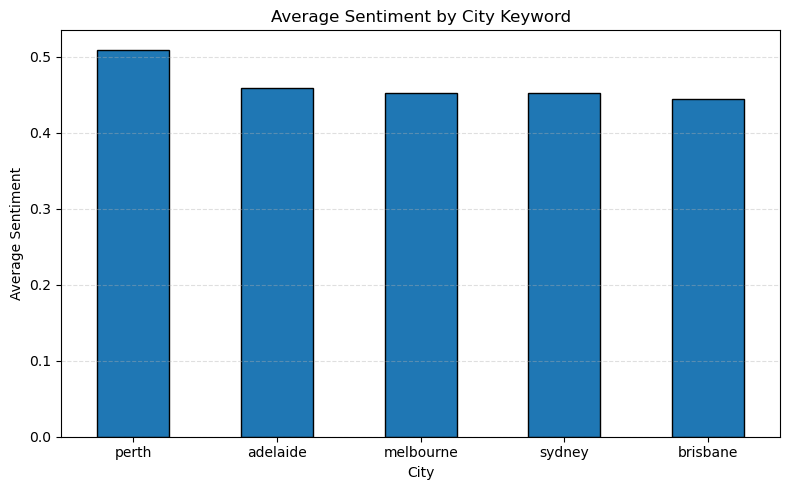

In [51]:
show_avg_by_city()

In [52]:
interact_city_month()

interactive(children=(Dropdown(description='City 1:', index=4, options=('perth', 'adelaide', 'melbourne', 'syd…

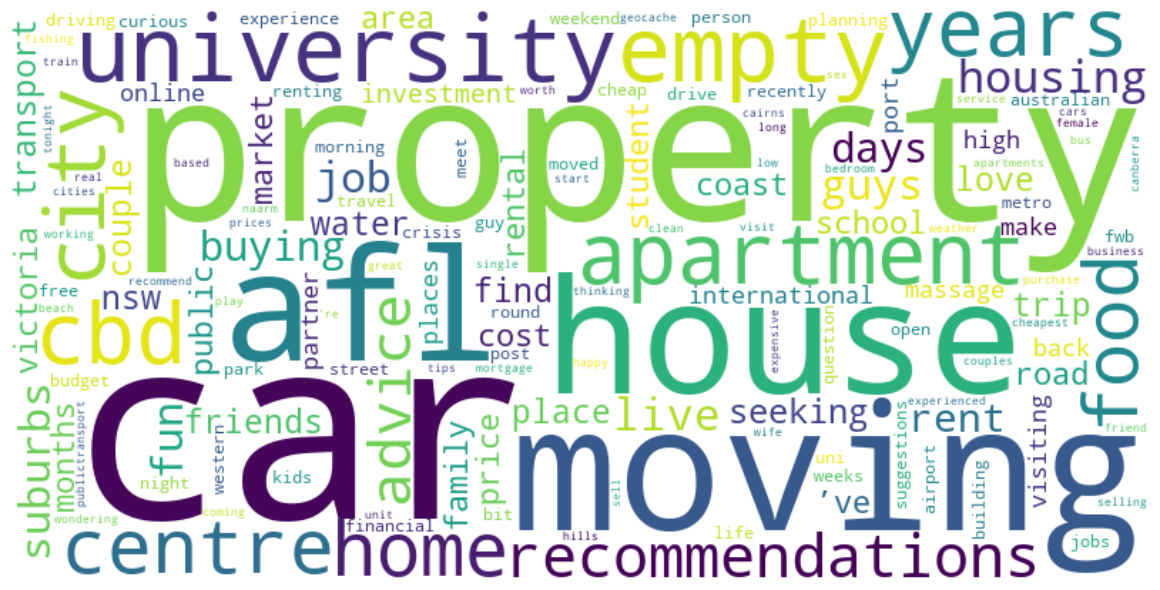

In [53]:
key_cloud()